In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chod 600 ~/.kaggle/kaggle.json

/bin/bash: line 1: chod: command not found


In [5]:
!pip install opendatasets

In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/abdallahwagih/kvasir-dataset-for-classification-and-segmentation")

Dataset URL: https://www.kaggle.com/datasets/abdallahwagih/kvasir-dataset-for-classification-and-segmentation


100%|██████████| 1.20G/1.20G [00:08<00:00, 155MB/s]


In [7]:


!pip install kagglehub
!pip install segmentation-models-pytorch

  Using cached segmentation_models_pytorch-0.5.0-py3-none-any.whl.metadata (17 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.

In [6]:
import os
import cv2 as cv
import numpy as np
from glob import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp


In [7]:
image_dir = "/content/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/images"
mask_dir = "/content/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/masks"
batch_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [8]:
from torch.utils.data import Dataset
import torch
import cv2 as cv
import numpy as np

class SegmentationData(Dataset):
    def __init__(self, img_paths: list, mask_paths: list, transform=None):
        super().__init__()
        self.img_paths = img_paths              # List of image file paths
        self.mask_paths = mask_paths            # List of corresponding mask file paths
        self.transform = transform              # Optional transform (e.g., data augmentation)

    def __len__(self):
        return len(self.img_paths)              # Return the total number of samples

    def __getitem__(self, index):
        # Read the image using OpenCV
        image = cv.imread(self.img_paths[index])
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)       # Convert image from BGR to RGB
        image = cv.resize(image, (256, 256))               # Resize image to 256x256
        image = image.astype('float32') / 255.0            # Normalize pixel values to [0,1]

        # Read the mask in grayscale mode
        mask = cv.imread(self.mask_paths[index], cv.IMREAD_GRAYSCALE)
        mask = cv.resize(mask, (256, 256))                 # Resize mask to 256x256
        mask = mask.astype('float32') / 255.0              # Normalize mask values to [0,1]
        mask = np.expand_dims(mask, axis=0)                # Add channel dimension (1, H, W)

        # Convert numpy arrays to torch tensors
        image = torch.tensor(image).permute(2, 0, 1)       # Change shape from (H, W, C) to (C, H, W)
        mask = torch.tensor(mask)                          # Mask is already (1, H, W)

        return image, mask                                 # Return image-mask pair


In [9]:
image_paths = sorted(glob(os.path.join(image_dir, "*jpg")))     # load & sort image paths
mask_paths = sorted(glob(os.path.join(mask_dir, "*jpg")))       # load & sort mask paths

train_images, val_images, train_mask, val_mask = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42)    # split into train & val (80/20)



In [10]:
train_dataset = SegmentationData(train_images, train_mask)
val_dataset = SegmentationData(val_images, val_mask)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [11]:
img, mask = train_dataset[1]
img.size(), mask.size()

(torch.Size([3, 256, 256]), torch.Size([1, 256, 256]))

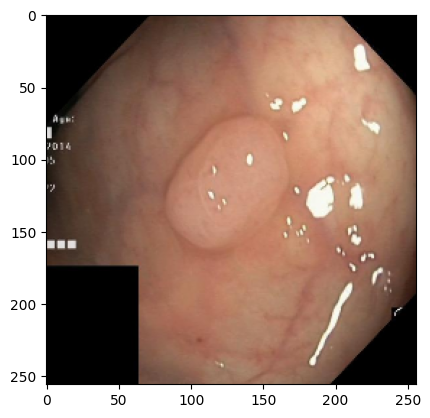

In [12]:
import matplotlib.pyplot as plt
plt.imshow(img.permute(1,2,0))

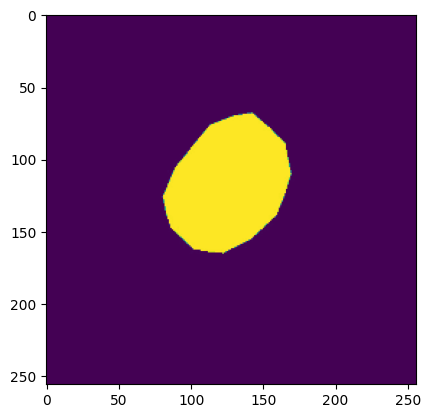

In [13]:
plt.imshow(mask.permute(1,2,0))

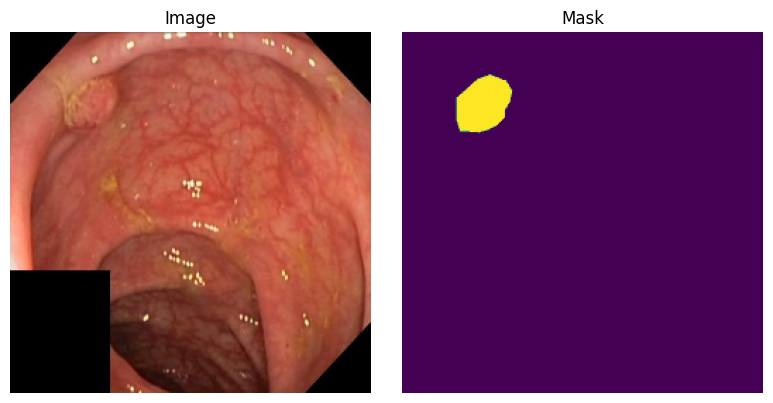

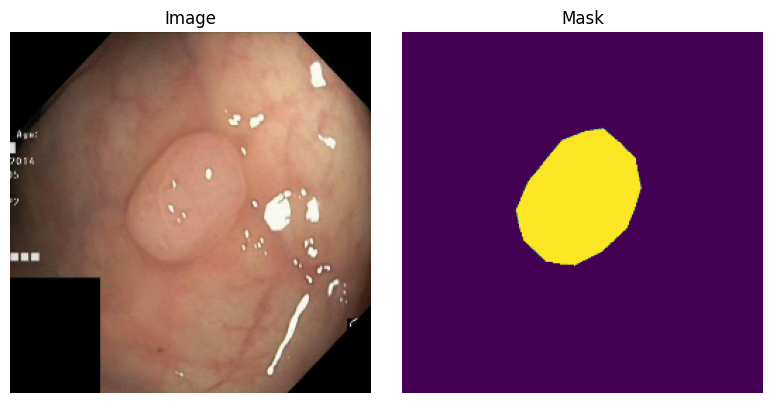

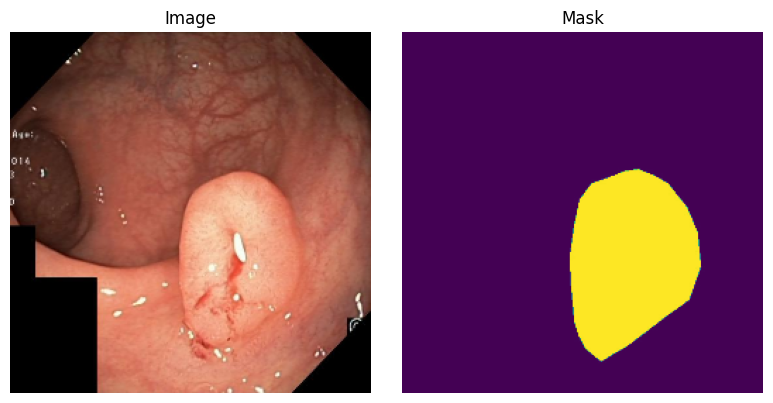

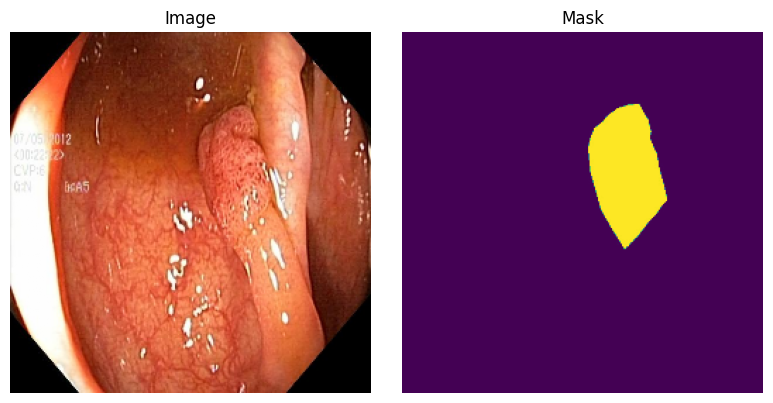

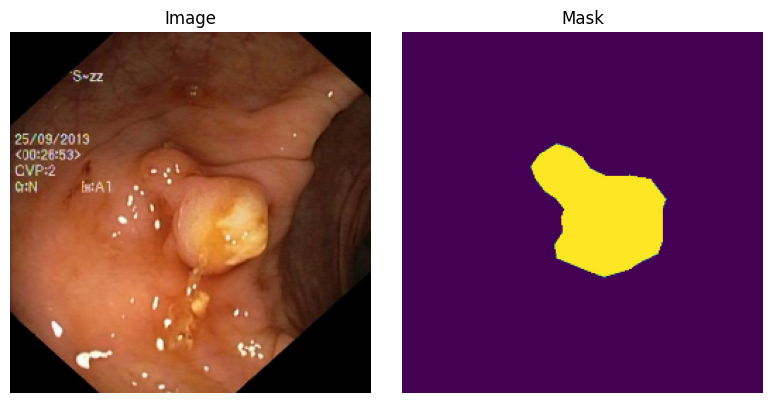

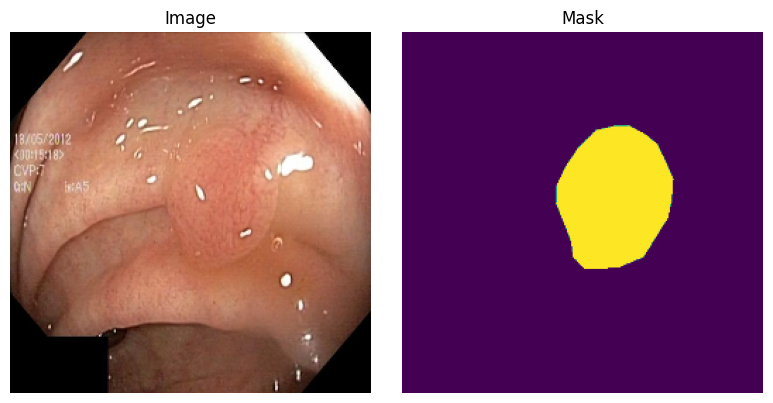

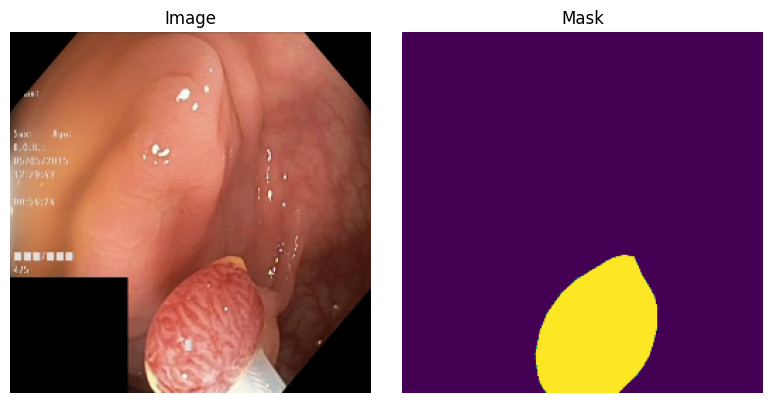

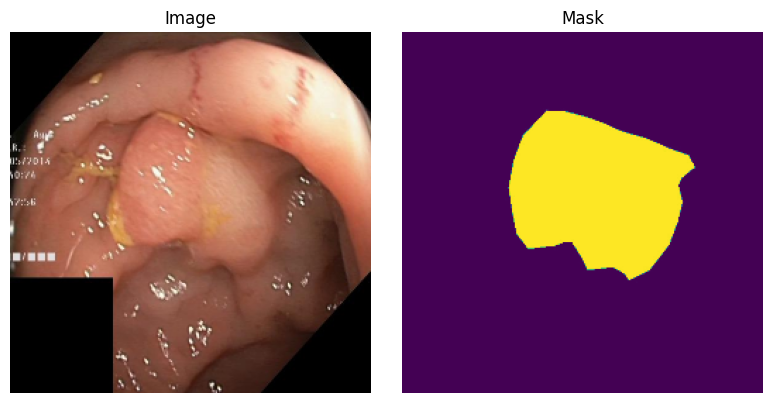

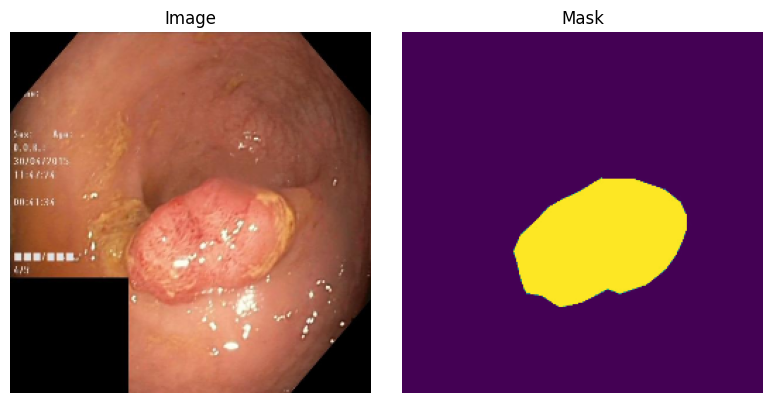

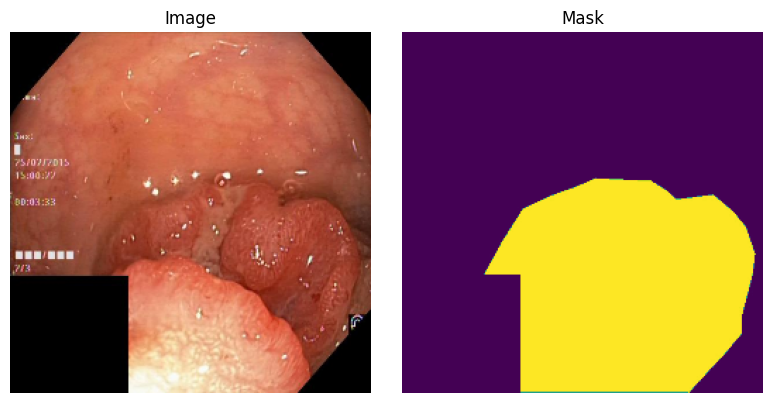

In [14]:

# Show first 10 samples from the training dataset
for i in range(10):
    img, mask = train_dataset[i]  # Get image and mask

    # Convert tensors to NumPy arrays for display
    # image_np = img.permute(1, 2, 0).numpy()        # (C, H, W) → (H, W, C)
    # mask_np = mask.squeeze().numpy()               # (1, H, W) → (H, W)

    # Create subplots: one row, two columns (image and mask)
    plt.figure(figsize=(8, 4))

    # Display the image
    plt.subplot(1, 2, 1)
    plt.imshow(img.permute(1,2,0))
    plt.title("Image")
    plt.axis('off')

    # Display the corresponding mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask.permute(1,2,0))
    plt.title("Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [15]:
model = smp.Unet(encode_name='resnet', encoder_weights='imagenet',in_channels=3, classes=1)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [19]:
best_loss = float("inf")
epochs = 10

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for images,mask in train_loader:
        images,mask = images.to(device), mask.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,mask)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, mask in val_loader:
            images,mask = images.to(device), mask.to(device)
            output = model(images)
            loss = criterion(output,mask)
            val_loss += loss.item()

    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)

    print(f"Epoch : {epoch}/{epochs}, Train Loss : {train_loss}, Val Loss : {val_loss}")

    if val_loss < best_loss:
        best_less = val_loss
        torch.save(model.state_dict(),"best_model.pth")




Epoch : 0/10, Train Loss : 0.05834602679197605, Val Loss : 0.16624332964420319
Epoch : 1/10, Train Loss : 0.05597440611857634, Val Loss : 0.30120088160037994
Epoch : 2/10, Train Loss : 0.06669522105501248, Val Loss : 0.21480481699109077
Epoch : 3/10, Train Loss : 0.054762652860238, Val Loss : 0.16377399861812592
Epoch : 4/10, Train Loss : 0.05027580461823023, Val Loss : 0.20297307148575783
Epoch : 5/10, Train Loss : 0.04687031960258117, Val Loss : 0.19810238480567932
Epoch : 6/10, Train Loss : 0.04049184631842833, Val Loss : 0.15435965172946453
Epoch : 7/10, Train Loss : 0.03763244172128347, Val Loss : 0.1626490969210863
Epoch : 8/10, Train Loss : 0.034245592470352464, Val Loss : 0.16045177355408669
Epoch : 9/10, Train Loss : 0.03637480449218016, Val Loss : 0.16790743172168732


In [26]:
def evaluate_model(model, val_loader):
    model.eval()
    test_loss = 0.0
    total_pixels = 0
    correct_pixels = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)  # raw logits
            loss = criterion(outputs, masks)
            test_loss += loss.item()

            preds = torch.sigmoid(outputs)               # apply sigmoid to get probabilities
            preds = (preds > 0.5).float()                # threshold to get binary mask

            correct_pixels += (preds == masks).sum().item()
            total_pixels += torch.numel(masks)

    avg_loss = test_loss / len(val_loader)
    accuracy = correct_pixels / total_pixels

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    torch.save(model.state_dict(),"best_model.pth")
evaluate_model(model, val_loader)


Test Loss: 0.1679
Test Accuracy: 0.9440


In [35]:
def infer_and_visualize(model, image_path,device):
  image = cv.imread(image_path)
  image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
  image = cv.resize(image, (256,256))
  image = image.astype('float') / 255.0

  # Convert to tensor and explicitly cast to float32
  image_tensor = torch.tensor(image, dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device)

  with torch.no_grad():
    output = model(image_tensor)
    output = torch.sigmoid(output).cpu().squeeze().numpy()

    output = (output > 0.5).astype(np.uint8)


    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    plt.title("Original Image")
    plt.imshow(image)


    plt.subplot(1,3,2)
    plt.title("Mask")
    plt.imshow(output)

    plt.subplot(1,3,3)
    plt.title("overlap")
    plt.imshow(image)
    plt.imshow(output,cmap='jet',alpha=0.5)
    plt.show()

In [28]:
model.load_state_dict(torch.load("/content/best_model.pth"))

<All keys matched successfully>

In [29]:
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

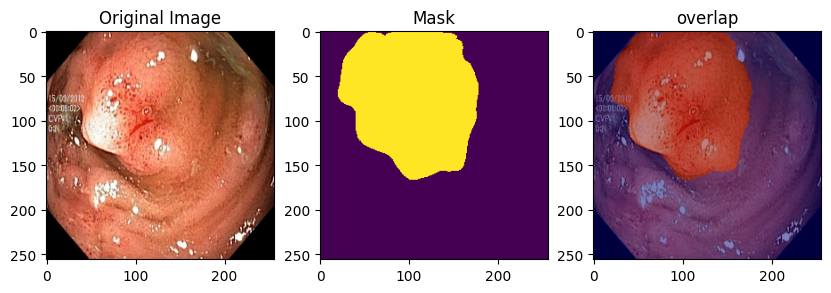

In [36]:
sample_image = "/content/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/images/cju0qkwl35piu0993l0dewei2.jpg"
infer_and_visualize(model,sample_image,device)

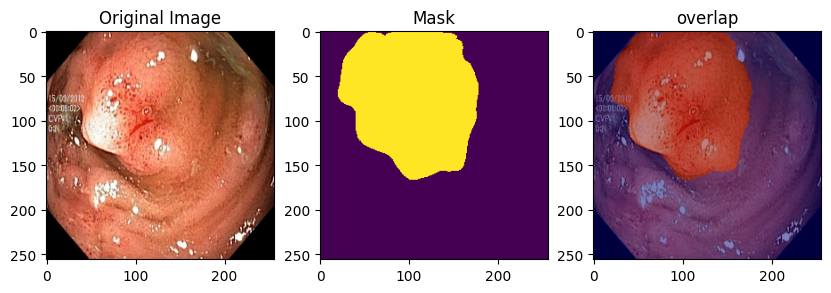

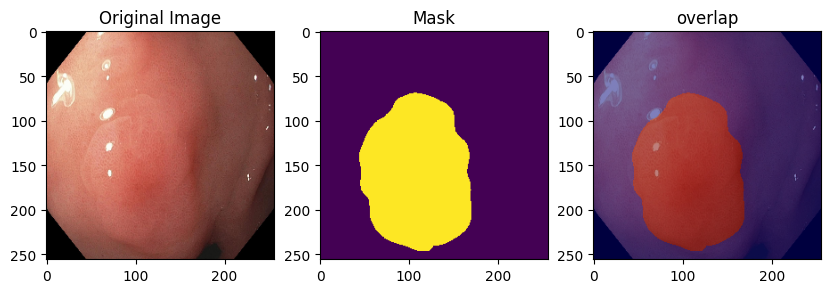

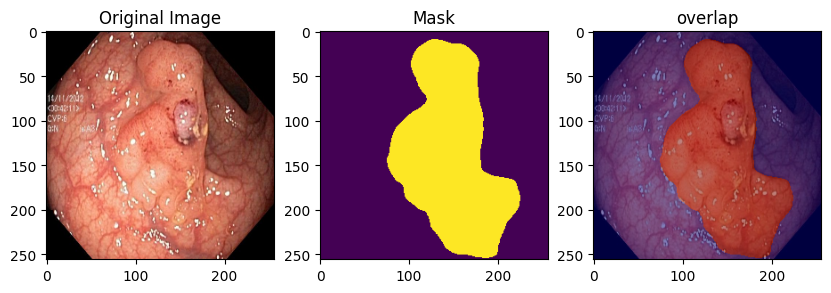

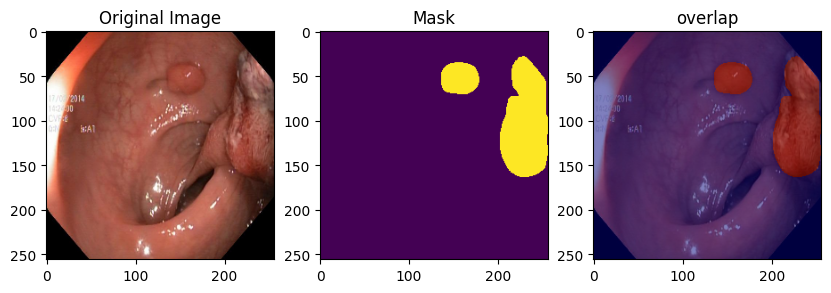

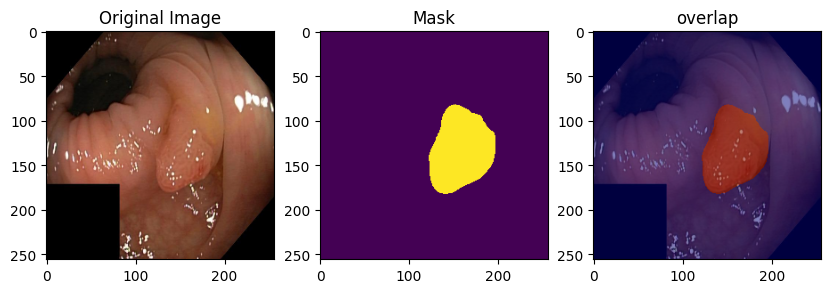

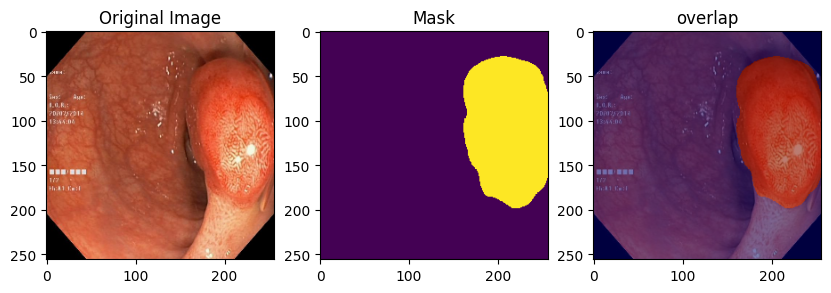

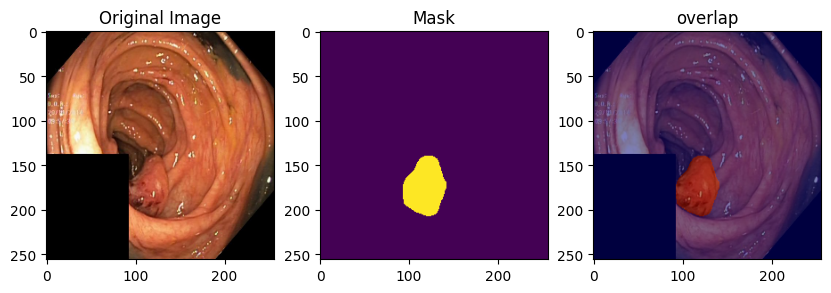

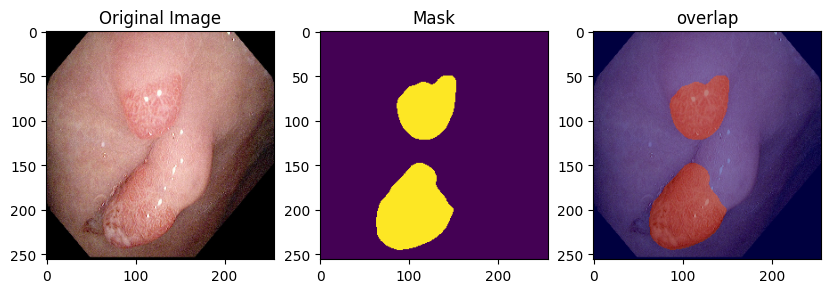

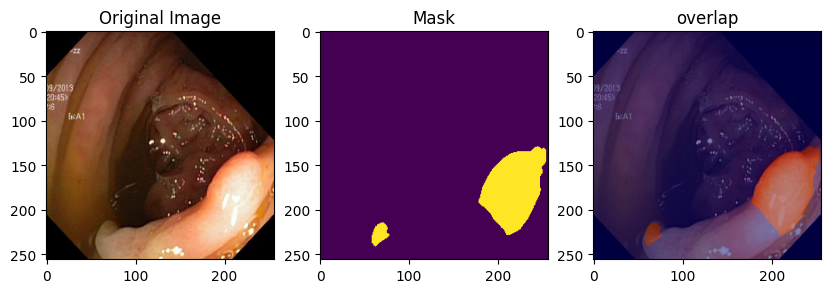

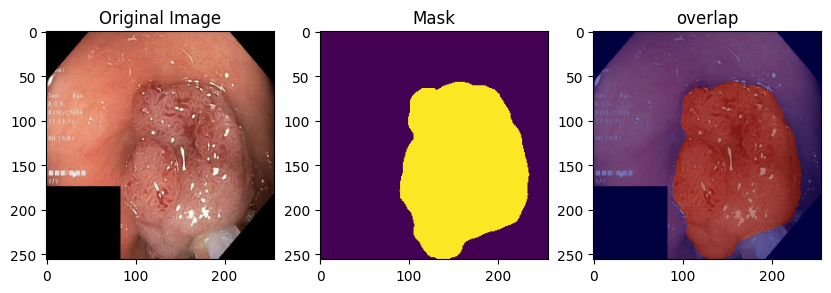

In [38]:

for i in range(10):
    sample_image = image_paths[i]  # Get the actual image path
    infer_and_visualize(model, sample_image, device)